# Spatial Multi-Object Image Generation (Internet Backgrounds)
**Author:** G8  
**Task:** 1.3 - Generate Spatial Multi-Object Images with Real Backgrounds  
**Timeline:** Feb 2025  

**Purpose:**
- Generate multi-object images with random spatial placement
- Use real internet backgrounds to increase difficulty
- Objects placed at random positions without overlap
- Variable object sizes for robustness

**Key Features:**
- Real backgrounds from internet (textures, surfaces, abstract)
- Objects maintain 224×224 SQUARE shape (key distinguishing feature)
- White/light border preserved to differentiate from background objects
- No grid structure - pure random placement

## Setup and Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import random
import requests
from io import BytesIO
from PIL import Image
import urllib.request
import ssl
import time

# Disable SSL verification for some image sources
ssl._create_default_https_context = ssl._create_unverified_context

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration

In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Canvas size (output image size)
CANVAS_SIZE = 896

# Object count range per image
MIN_OBJECTS = 1
MAX_OBJECTS = 9

# Object size range (pixels) - IMPORTANT: Keep objects roughly square
MIN_OBJ_SIZE = 80
MAX_OBJ_SIZE = 180

# White border to preserve around objects (helps distinguish from background)
BORDER_WIDTH = 3  # pixels of white border

# Minimum spacing between objects (pixels)
MIN_SPACING = 20

# Number of images to generate
NUM_IMAGES = 3000

# Number of background images to download
NUM_BACKGROUNDS = 200

# Train/Val/Test split ratios
SPLIT_RATIOS = {'train': 0.70, 'val': 0.15, 'test': 0.15}

# =============================================================================
# PATHS
# =============================================================================
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "single_objects" / "train"
OUTPUT_BASE = PROJECT_ROOT / "data" / "multi_objects_spatial"
OUTPUT_IMAGES = OUTPUT_BASE / "images"
OUTPUT_LABELS = OUTPUT_BASE / "labels"
BACKGROUNDS_PATH = OUTPUT_BASE / "backgrounds"
STATS_PATH = PROJECT_ROOT / "data" / "statistics"

# Create directories
for path in [OUTPUT_IMAGES, OUTPUT_LABELS, BACKGROUNDS_PATH, STATS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

# Load class mapping
with open(PROJECT_ROOT / "data" / "class_mapping.json", 'r') as f:
    class_mapping = json.load(f)

print("Configuration:")
print(f"  Canvas size: {CANVAS_SIZE}x{CANVAS_SIZE}")
print(f"  Objects per image: {MIN_OBJECTS}-{MAX_OBJECTS}")
print(f"  Object size range: {MIN_OBJ_SIZE}-{MAX_OBJ_SIZE} pixels")
print(f"  Border width: {BORDER_WIDTH} pixels (white border preserved)")
print(f"  Total images: {NUM_IMAGES}")
print(f"  Background images: {NUM_BACKGROUNDS}")
print(f"  Total classes: {class_mapping['num_classes']}")

Configuration:
  Canvas size: 896x896
  Objects per image: 1-9
  Object size range: 80-180 pixels
  Border width: 3 pixels (white border preserved)
  Total images: 3000
  Background images: 200
  Total classes: 39


## Download Internet Backgrounds

In [3]:
# =============================================================================
# SAFE BACKGROUND SOURCES
# These are textures/surfaces unlikely to contain objects similar to our classes
# =============================================================================

# Picsum (Lorem Picsum) - random photos
PICSUM_URLS = [f"https://picsum.photos/{CANVAS_SIZE}/{CANVAS_SIZE}?random={i}" for i in range(100)]

# Specific texture/pattern URLs (safe backgrounds)
TEXTURE_KEYWORDS = [
    "wood+texture", "marble+texture", "concrete+texture", "paper+texture",
    "fabric+texture", "stone+texture", "brick+wall", "grass+texture",
    "sand+texture", "water+texture", "sky+clouds", "floor+tiles",
    "carpet+texture", "leather+texture", "metal+texture", "rust+texture"
]

def download_picsum_background(save_path, idx):
    """
    Download a random image from Picsum
    """
    try:
        url = f"https://picsum.photos/{CANVAS_SIZE}/{CANVAS_SIZE}?random={idx + random.randint(1000, 9999)}"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')
            img = img.resize((CANVAS_SIZE, CANVAS_SIZE))
            img.save(save_path)
            return True
    except Exception as e:
        pass
    return False


def create_synthetic_background(size):
    """
    Create synthetic textured backgrounds as fallback
    """
    bg_type = random.choice(['noise', 'gradient', 'pattern', 'perlin'])
    
    if bg_type == 'noise':
        # Colored noise
        base_color = np.random.randint(100, 200, 3)
        noise = np.random.randint(-50, 50, (size, size, 3))
        bg = np.clip(base_color + noise, 0, 255).astype(np.uint8)
        
    elif bg_type == 'gradient':
        # Multi-directional gradient
        color1 = np.random.randint(50, 200, 3)
        color2 = np.random.randint(50, 200, 3)
        bg = np.zeros((size, size, 3), dtype=np.uint8)
        for y in range(size):
            for x in range(size):
                ratio = (x + y) / (2 * size)
                bg[y, x] = (color1 * (1 - ratio) + color2 * ratio).astype(np.uint8)
        # Add noise
        noise = np.random.randint(-20, 20, (size, size, 3))
        bg = np.clip(bg.astype(int) + noise, 0, 255).astype(np.uint8)
        
    elif bg_type == 'pattern':
        # Checkerboard or stripe pattern
        bg = np.zeros((size, size, 3), dtype=np.uint8)
        color1 = np.random.randint(100, 180, 3)
        color2 = np.random.randint(120, 200, 3)
        block_size = random.randint(20, 60)
        for y in range(0, size, block_size):
            for x in range(0, size, block_size):
                color = color1 if ((x // block_size) + (y // block_size)) % 2 == 0 else color2
                bg[y:y+block_size, x:x+block_size] = color
        # Add noise
        noise = np.random.randint(-15, 15, (size, size, 3))
        bg = np.clip(bg.astype(int) + noise, 0, 255).astype(np.uint8)
        
    else:  # perlin-like
        # Simplified perlin-like noise
        base = np.random.randint(80, 180, 3)
        # Create smooth noise at different scales
        bg = np.full((size, size, 3), base, dtype=np.float32)
        for scale in [64, 32, 16, 8]:
            small = np.random.randn(size // scale + 1, size // scale + 1, 3) * (scale / 2)
            large = cv2.resize(small, (size, size), interpolation=cv2.INTER_CUBIC)
            bg += large
        bg = np.clip(bg, 0, 255).astype(np.uint8)
    
    return bg


print("="*80)
print("DOWNLOADING/CREATING BACKGROUNDS")
print("="*80)

existing_backgrounds = list(BACKGROUNDS_PATH.glob("*.jpg"))
print(f"\nExisting backgrounds: {len(existing_backgrounds)}")

if len(existing_backgrounds) < NUM_BACKGROUNDS:
    needed = NUM_BACKGROUNDS - len(existing_backgrounds)
    print(f"Need to create {needed} more backgrounds...")
    
    # Try downloading from Picsum first
    downloaded = 0
    print("\nDownloading from Picsum...")
    for i in tqdm(range(min(needed, 100)), desc="Downloading"):
        save_path = BACKGROUNDS_PATH / f"bg_picsum_{len(existing_backgrounds) + downloaded:04d}.jpg"
        if download_picsum_background(save_path, i):
            downloaded += 1
        time.sleep(0.2)  # Rate limiting
    
    print(f"Downloaded {downloaded} images from Picsum")
    
    # Create synthetic backgrounds for the rest
    remaining = needed - downloaded
    if remaining > 0:
        print(f"\nCreating {remaining} synthetic backgrounds...")
        for i in tqdm(range(remaining), desc="Creating synthetic"):
            bg = create_synthetic_background(CANVAS_SIZE)
            save_path = BACKGROUNDS_PATH / f"bg_synthetic_{len(existing_backgrounds) + downloaded + i:04d}.jpg"
            cv2.imwrite(str(save_path), cv2.cvtColor(bg, cv2.COLOR_RGB2BGR))

# Reload backgrounds
all_backgrounds = list(BACKGROUNDS_PATH.glob("*.jpg"))
print(f"\nTotal backgrounds available: {len(all_backgrounds)}")

DOWNLOADING/CREATING BACKGROUNDS

Existing backgrounds: 0
Need to create 200 more backgrounds...



Downloading: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Downloaded 100 images from Picsum

Creating 100 synthetic backgrounds...


Creating synthetic: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Total backgrounds available: 200


## Visualize Sample Backgrounds

Sample backgrounds:


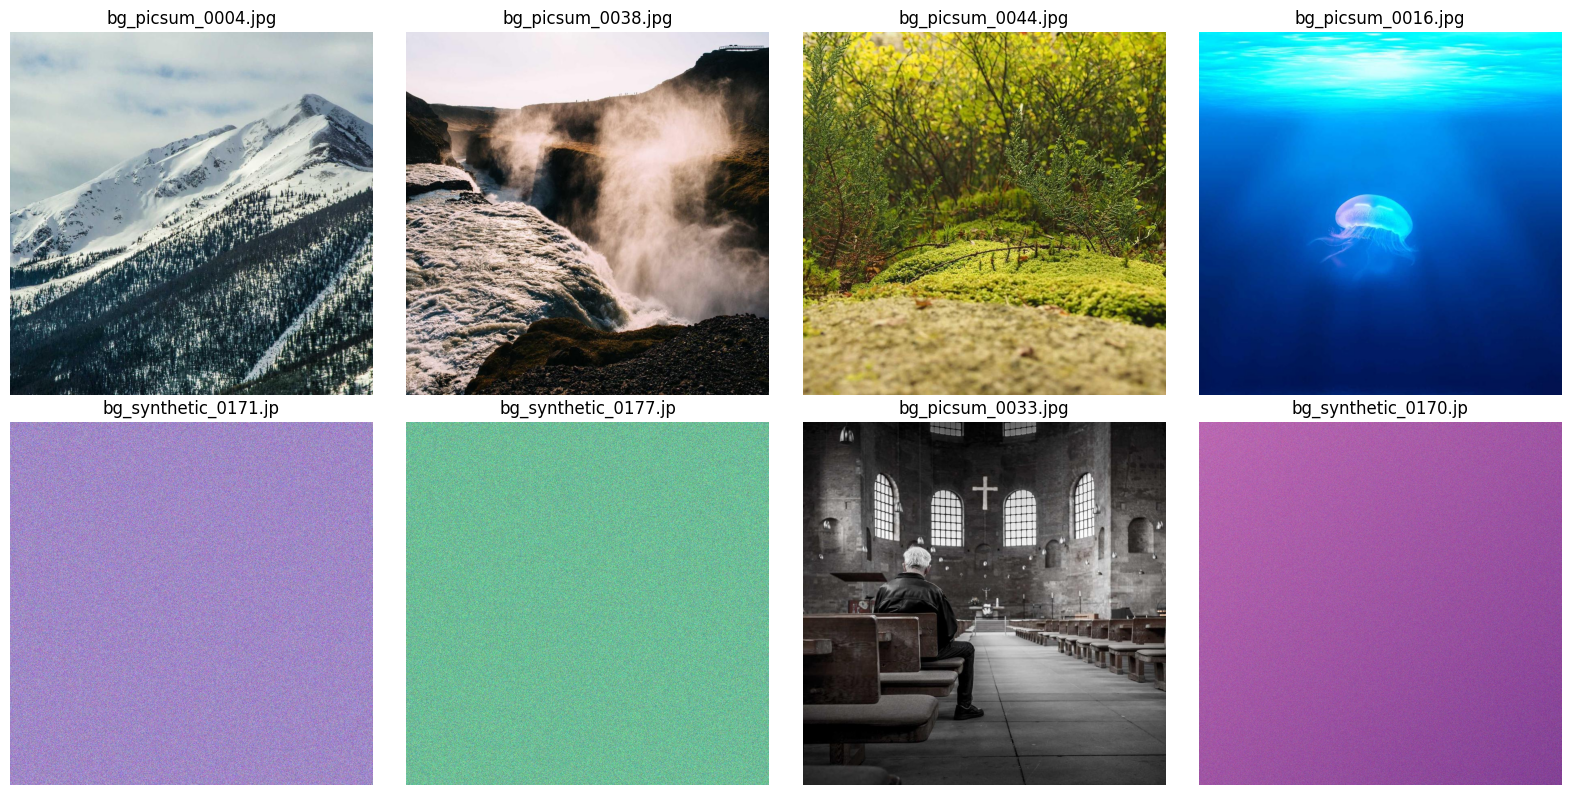

In [4]:
# Show sample backgrounds
print("Sample backgrounds:")
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

sample_bgs = random.sample(all_backgrounds, min(8, len(all_backgrounds)))
for idx, bg_path in enumerate(sample_bgs):
    img = cv2.imread(str(bg_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img)
    axes[idx].set_title(bg_path.name[:20])
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(STATS_PATH / "sample_backgrounds.png", dpi=150)
plt.show()

## Load Processed Object Images

In [5]:
def load_image_paths():
    """
    Load all preprocessed image paths organized by class
    """
    print("="*80)
    print("LOADING PROCESSED OBJECT IMAGES")
    print("="*80)
    
    image_dict = {}
    
    for obj_folder in PROCESSED_PATH.iterdir():
        if obj_folder.is_dir():
            obj_id = obj_folder.name
            images = sorted(list(obj_folder.glob("*.jpg")))
            if len(images) > 0:
                image_dict[obj_id] = images
    
    total_images = sum(len(imgs) for imgs in image_dict.values())
    
    print(f"\nLoaded {len(image_dict)} object classes")
    print(f"Total images available: {total_images}")
    
    return image_dict


image_paths = load_image_paths()

LOADING PROCESSED OBJECT IMAGES

Loaded 39 object classes
Total images available: 2943


## Spatial Placement Functions with Border Preservation

TESTING SPATIAL IMAGE GENERATION
Canvas shape: (896, 896, 3)
Objects placed: 4
Background: bg_synthetic_0117.jpg


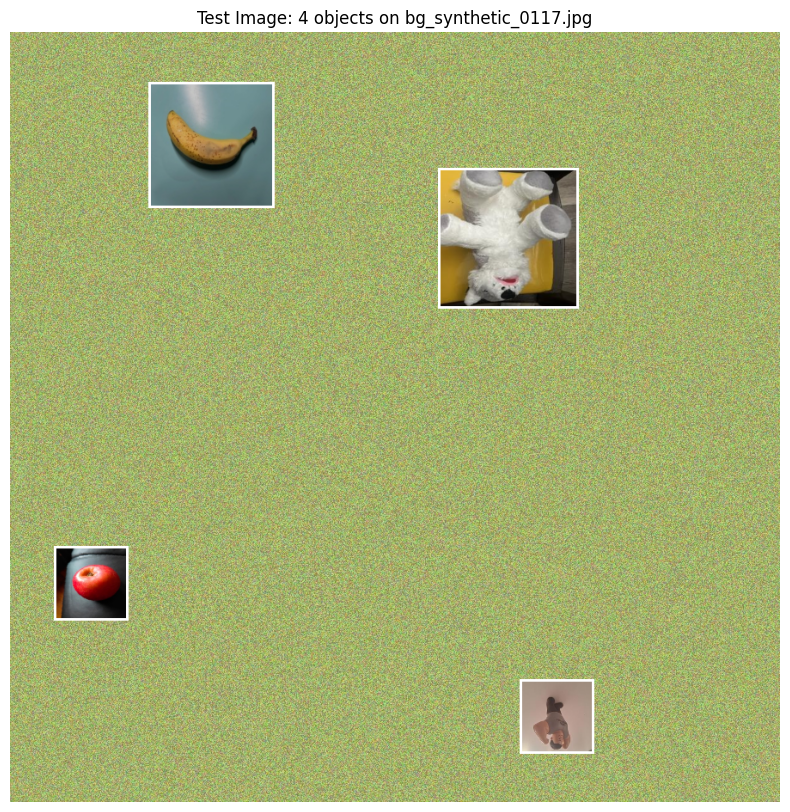

In [6]:
def check_overlap(new_box, existing_boxes, min_spacing):
    """
    Check if new_box overlaps with any existing boxes
    """
    nx1, ny1, nx2, ny2 = new_box
    
    for ex1, ey1, ex2, ey2 in existing_boxes:
        # Add spacing
        ex1 -= min_spacing
        ey1 -= min_spacing
        ex2 += min_spacing
        ey2 += min_spacing
        
        # Check overlap
        if not (nx2 < ex1 or nx1 > ex2 or ny2 < ey1 or ny1 > ey2):
            return True
    
    return False


def add_white_border(img, border_width):
    """
    Add white border around object image
    This helps distinguish our objects from background objects
    
    Our objects have characteristic:
    - 224x224 original size (scaled to target size)
    - SQUARE shape
    - White/light background from preprocessing
    - Border added here for extra distinction
    """
    if border_width <= 0:
        return img
    
    h, w = img.shape[:2]
    
    # Create white border by making edges white
    bordered = img.copy()
    
    # Top and bottom borders
    bordered[:border_width, :] = 255
    bordered[-border_width:, :] = 255
    
    # Left and right borders
    bordered[:, :border_width] = 255
    bordered[:, -border_width:] = 255
    
    return bordered


def create_spatial_image_with_background(image_paths_dict, class_mapping, backgrounds, config):
    """
    Create an image with randomly placed objects on real background
    
    KEY FEATURES:
    - Objects are ALWAYS SQUARE (distinguishing feature)
    - Objects have white border (helps model distinguish from bg objects)
    - Real backgrounds increase difficulty
    """
    canvas_size = config['canvas_size']
    min_objects = config['min_objects']
    max_objects = config['max_objects']
    min_obj_size = config['min_obj_size']
    max_obj_size = config['max_obj_size']
    min_spacing = config['min_spacing']
    border_width = config['border_width']
    
    # Load random background
    bg_path = random.choice(backgrounds)
    canvas = cv2.imread(str(bg_path))
    canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    
    # Ensure correct size
    if canvas.shape[0] != canvas_size or canvas.shape[1] != canvas_size:
        canvas = cv2.resize(canvas, (canvas_size, canvas_size))
    
    # Determine number of objects
    num_objects = random.randint(min_objects, max_objects)
    
    # Select object classes
    available_classes = list(image_paths_dict.keys())
    if num_objects <= len(available_classes):
        selected_classes = random.sample(available_classes, num_objects)
    else:
        selected_classes = random.choices(available_classes, k=num_objects)
    
    annotations = []
    placed_boxes = []
    placed_objects = []
    max_attempts = 100
    
    for obj_id in selected_classes:
        # Random object size (SQUARE - same width and height)
        obj_size = random.randint(min_obj_size, max_obj_size)
        
        # Try to place object
        placed = False
        for _ in range(max_attempts):
            # Random position
            x1 = random.randint(0, canvas_size - obj_size)
            y1 = random.randint(0, canvas_size - obj_size)
            x2 = x1 + obj_size
            y2 = y1 + obj_size
            
            new_box = (x1, y1, x2, y2)
            
            if not check_overlap(new_box, placed_boxes, min_spacing):
                # Load object image
                img_path = random.choice(image_paths_dict[obj_id])
                obj_img = cv2.imread(str(img_path))
                obj_img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB)
                
                # Resize to target size (KEEP SQUARE)
                obj_img = cv2.resize(obj_img, (obj_size, obj_size))
                
                # Add white border (KEY DISTINGUISHING FEATURE)
                obj_img = add_white_border(obj_img, border_width)
                
                # Optional: Random small rotation (keeps square shape)
                if random.random() < 0.2:
                    k = random.randint(1, 3)
                    obj_img = np.rot90(obj_img, k)
                
                # Place on canvas
                canvas[y1:y2, x1:x2] = obj_img
                
                # Record
                placed_boxes.append(new_box)
                placed_objects.append(obj_id)
                
                # YOLO annotation (normalized)
                class_idx = class_mapping['class_to_idx'][obj_id]
                x_center = (x1 + obj_size / 2) / canvas_size
                y_center = (y1 + obj_size / 2) / canvas_size
                # Width and height are EQUAL (square)
                box_w = obj_size / canvas_size
                box_h = obj_size / canvas_size
                
                annotations.append(
                    f"{class_idx} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}"
                )
                
                placed = True
                break
    
    metadata = {
        'num_objects': len(annotations),
        'object_ids': placed_objects,
        'background': bg_path.name
    }
    
    return canvas, annotations, metadata


# Test
print("="*80)
print("TESTING SPATIAL IMAGE GENERATION")
print("="*80)

test_config = {
    'canvas_size': CANVAS_SIZE,
    'min_objects': 3,
    'max_objects': 5,
    'min_obj_size': MIN_OBJ_SIZE,
    'max_obj_size': MAX_OBJ_SIZE,
    'min_spacing': MIN_SPACING,
    'border_width': BORDER_WIDTH,
}

test_canvas, test_annot, test_meta = create_spatial_image_with_background(
    image_paths, class_mapping, all_backgrounds, test_config
)

print(f"Canvas shape: {test_canvas.shape}")
print(f"Objects placed: {test_meta['num_objects']}")
print(f"Background: {test_meta['background']}")

# Visualize
plt.figure(figsize=(10, 10))
plt.imshow(test_canvas)
plt.title(f"Test Image: {test_meta['num_objects']} objects on {test_meta['background']}")
plt.axis('off')
plt.show()

## Generate All Spatial Images

In [7]:
print("="*80)
print("GENERATING SPATIAL IMAGES WITH INTERNET BACKGROUNDS")
print("="*80)

# Configuration
gen_config = {
    'canvas_size': CANVAS_SIZE,
    'min_objects': MIN_OBJECTS,
    'max_objects': MAX_OBJECTS,
    'min_obj_size': MIN_OBJ_SIZE,
    'max_obj_size': MAX_OBJ_SIZE,
    'min_spacing': MIN_SPACING,
    'border_width': BORDER_WIDTH,
}

# Create temporary folder
temp_images = OUTPUT_IMAGES / "all_generated"
temp_labels = OUTPUT_LABELS / "all_generated"
temp_images.mkdir(parents=True, exist_ok=True)
temp_labels.mkdir(parents=True, exist_ok=True)

# Track statistics
object_counts = []
backgrounds_used = []

print(f"\nGenerating {NUM_IMAGES} spatial images...")
print(f"  Canvas size: {CANVAS_SIZE}x{CANVAS_SIZE}")
print(f"  Objects per image: {MIN_OBJECTS}-{MAX_OBJECTS}")
print(f"  Object sizes: {MIN_OBJ_SIZE}-{MAX_OBJ_SIZE} (SQUARE)")
print(f"  Border width: {BORDER_WIDTH}px (white border)")
print(f"  Background images: {len(all_backgrounds)}")

for i in tqdm(range(NUM_IMAGES), desc="Generating"):
    # Generate image
    canvas, annotations, metadata = create_spatial_image_with_background(
        image_paths, class_mapping, all_backgrounds, gen_config
    )
    
    num_obj = metadata['num_objects']
    object_counts.append(num_obj)
    backgrounds_used.append(metadata['background'])
    
    # Save image
    img_filename = f"spatial_{i:05d}_obj{num_obj}.jpg"
    img_path = temp_images / img_filename
    cv2.imwrite(str(img_path), cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
    
    # Save annotation
    label_filename = f"spatial_{i:05d}_obj{num_obj}.txt"
    label_path = temp_labels / label_filename
    with open(label_path, 'w') as f:
        f.write('\n'.join(annotations))

print("\n" + "="*80)
print("GENERATION COMPLETE")
print("="*80)
print(f"\nTotal images generated: {NUM_IMAGES}")
print(f"Unique backgrounds used: {len(set(backgrounds_used))}")

GENERATING SPATIAL IMAGES WITH INTERNET BACKGROUNDS

Generating 3000 spatial images...
  Canvas size: 896x896
  Objects per image: 1-9
  Object sizes: 80-180 (SQUARE)
  Border width: 3px (white border)
  Background images: 200


Generating: 100%|██████████| 3000/3000 [00:28<00:00, 107.11it/s]


GENERATION COMPLETE

Total images generated: 3000
Unique backgrounds used: 200


## Split Dataset

In [8]:
print("="*80)
print("SPLITTING DATASET")
print("="*80)

# Get all generated images
all_images = sorted(list(temp_images.glob("*.jpg")))
all_labels = sorted(list(temp_labels.glob("*.txt")))

print(f"\nTotal images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")

# Shuffle
combined = list(zip(all_images, all_labels))
random.shuffle(combined)

# Calculate split indices
n = len(combined)
train_end = int(n * SPLIT_RATIOS['train'])
val_end = train_end + int(n * SPLIT_RATIOS['val'])

splits = {
    'train': combined[:train_end],
    'val': combined[train_end:val_end],
    'test': combined[val_end:]
}

# Copy to split folders
for split_name, data in splits.items():
    img_folder = OUTPUT_IMAGES / split_name
    label_folder = OUTPUT_LABELS / split_name
    img_folder.mkdir(parents=True, exist_ok=True)
    label_folder.mkdir(parents=True, exist_ok=True)
    
    print(f"\nCopying {len(data)} images to {split_name}...")
    
    for img_path, label_path in tqdm(data, desc=split_name):
        shutil.copy2(img_path, img_folder / img_path.name)
        shutil.copy2(label_path, label_folder / label_path.name)

print("\n" + "="*80)
print("SPLIT COMPLETE")
print("="*80)
for split_name, data in splits.items():
    print(f"  {split_name.capitalize()}: {len(data)} ({len(data)/n*100:.1f}%)")

SPLITTING DATASET

Total images: 3725
Total labels: 3725

Copying 2607 images to train...


train: 100%|██████████| 2607/2607 [00:01<00:00, 1395.59it/s]



Copying 558 images to val...


val: 100%|██████████| 558/558 [00:00<00:00, 1377.29it/s]



Copying 560 images to test...


test: 100%|██████████| 560/560 [00:00<00:00, 1012.89it/s]


SPLIT COMPLETE
  Train: 2607 (70.0%)
  Val: 558 (15.0%)
  Test: 560 (15.0%)


## Create data.yaml for YOLOv8

In [9]:
print("="*80)
print("CREATING data_spatial.yaml")
print("="*80)

data_yaml_path = PROJECT_ROOT / "data" / "data_spatial.yaml"

yaml_content = f"""# YOLOv8 Spatial Dataset Configuration
# Generated for CNN Attendance System Project
# 
# KEY FEATURES:
# - Objects are ALWAYS SQUARE (224x224 original, scaled to 80-180px)
# - Objects have WHITE BORDER ({BORDER_WIDTH}px) to distinguish from background
# - Real internet backgrounds for increased difficulty
# - Random spatial placement (no grid structure)

path: {OUTPUT_BASE.absolute()}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: {class_mapping['num_classes']}

# Class names
names:
"""

idx_to_class = class_mapping['idx_to_class']
for idx in range(class_mapping['num_classes']):
    class_name = idx_to_class[str(idx)]
    yaml_content += f"  {idx}: {class_name}\n"

with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"\nSaved: {data_yaml_path}")

CREATING data_spatial.yaml

Saved: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/data_spatial.yaml


## Visualize Samples

VISUALIZING SAMPLES


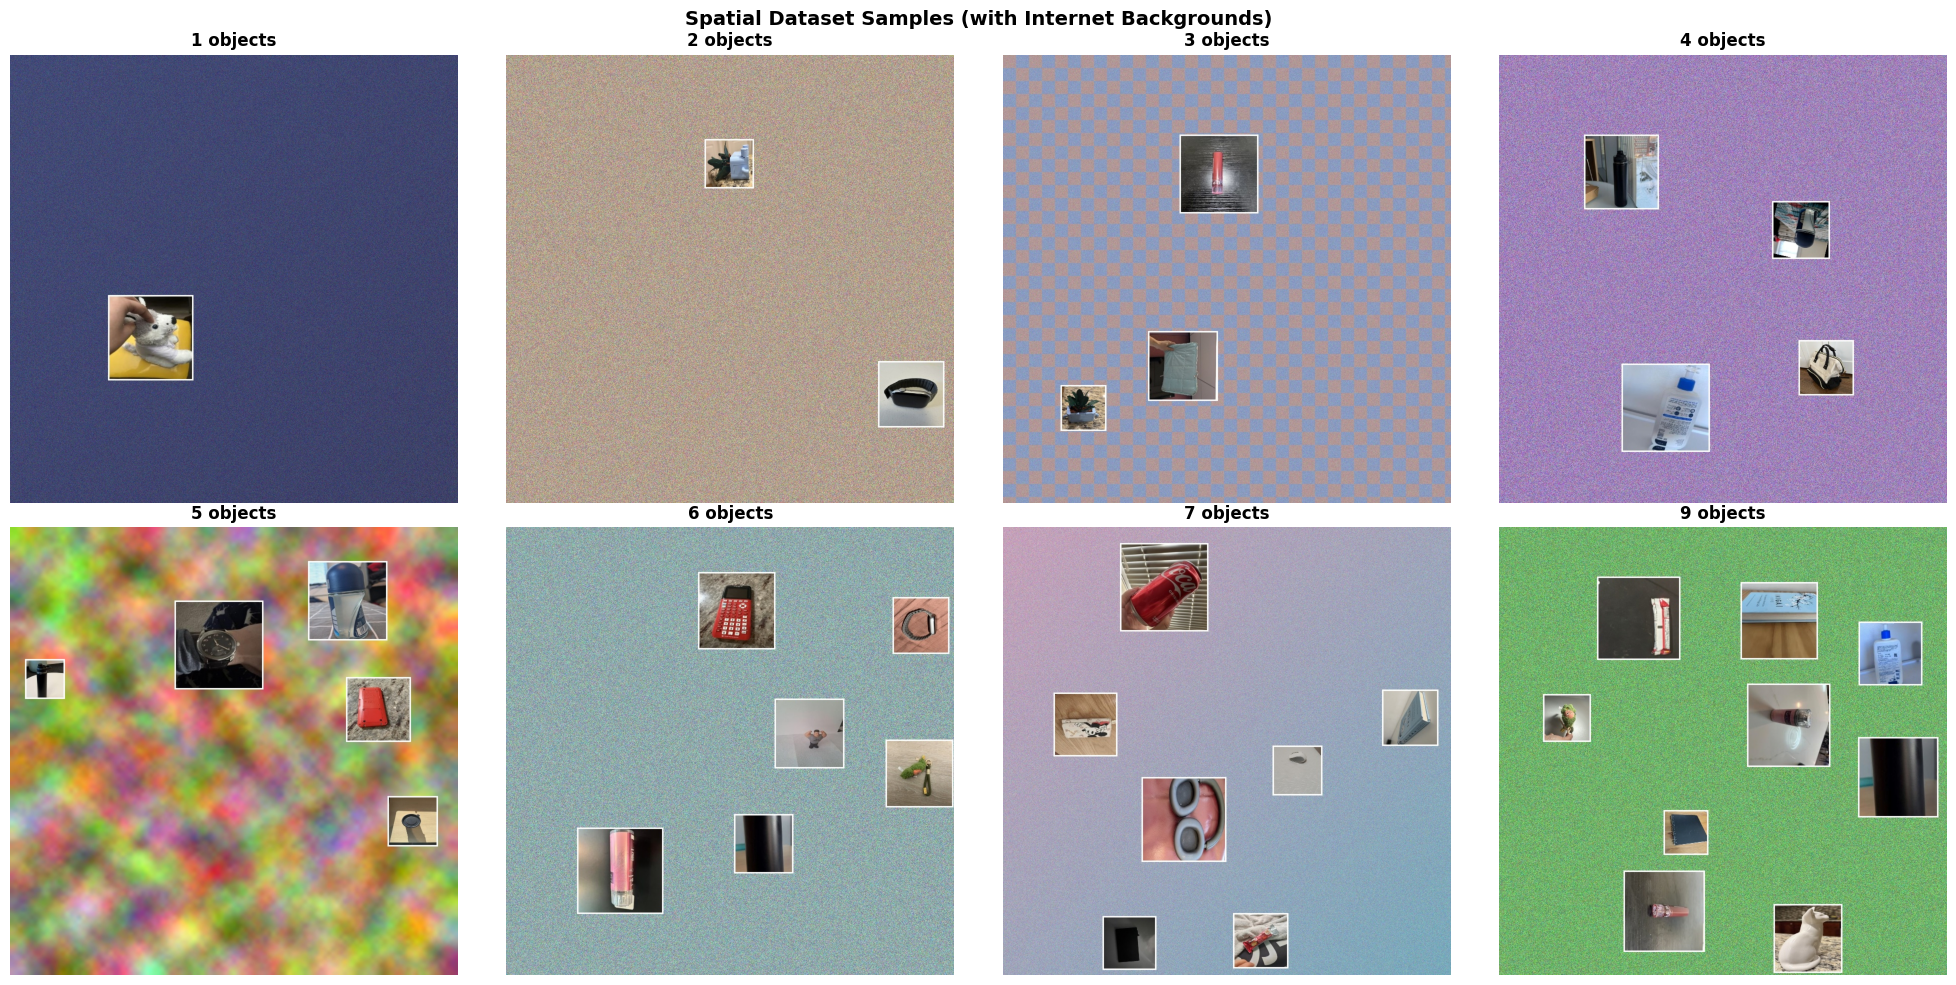

In [10]:
print("="*80)
print("VISUALIZING SAMPLES")
print("="*80)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

train_path = OUTPUT_IMAGES / "train"
train_images = list(train_path.glob("*.jpg"))

# Select samples with different object counts
selected = []
for target_count in [1, 2, 3, 4, 5, 6, 7, 9]:
    for img_path in train_images:
        if f"_obj{target_count}." in img_path.name:
            selected.append(img_path)
            break

for idx, img_path in enumerate(selected[:8]):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    obj_count = img_path.stem.split('_obj')[-1]
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{obj_count} objects", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Spatial Dataset Samples (with Internet Backgrounds)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(STATS_PATH / "spatial_samples_overview.png", dpi=150, bbox_inches='tight')
plt.show()

## Statistics

DATASET STATISTICS

Object count distribution:
  1 objects:  329 ( 11.0%) █████
  2 objects:  334 ( 11.1%) █████
  3 objects:  317 ( 10.6%) █████
  4 objects:  332 ( 11.1%) █████
  5 objects:  315 ( 10.5%) █████
  6 objects:  332 ( 11.1%) █████
  7 objects:  334 ( 11.1%) █████
  8 objects:  345 ( 11.5%) █████
  9 objects:  362 ( 12.1%) ██████


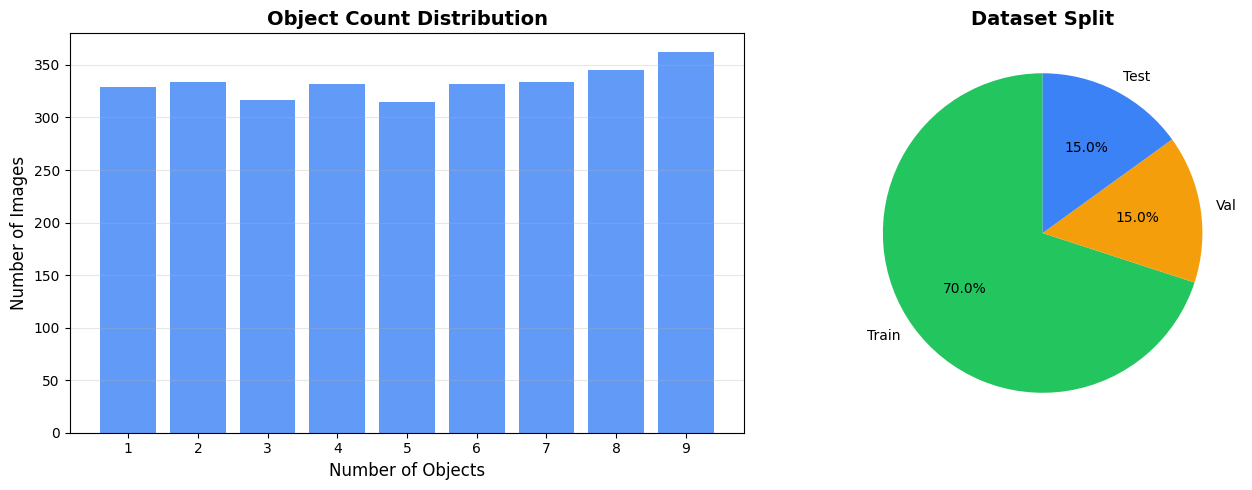

In [11]:
print("="*80)
print("DATASET STATISTICS")
print("="*80)

# Object count distribution
print("\nObject count distribution:")
for count in range(MIN_OBJECTS, MAX_OBJECTS + 1):
    num = object_counts.count(count)
    pct = num / len(object_counts) * 100
    bar = '█' * int(pct / 2)
    print(f"  {count} objects: {num:4d} ({pct:5.1f}%) {bar}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Object count histogram
ax1 = axes[0]
counts_hist = [object_counts.count(i) for i in range(MIN_OBJECTS, MAX_OBJECTS + 1)]
ax1.bar(range(MIN_OBJECTS, MAX_OBJECTS + 1), counts_hist, color='#3b82f6', alpha=0.8)
ax1.set_xlabel('Number of Objects', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Object Count Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks(range(MIN_OBJECTS, MAX_OBJECTS + 1))
ax1.grid(True, alpha=0.3, axis='y')

# Split distribution
ax2 = axes[1]
split_counts = [
    len(list((OUTPUT_IMAGES / 'train').glob('*.jpg'))),
    len(list((OUTPUT_IMAGES / 'val').glob('*.jpg'))),
    len(list((OUTPUT_IMAGES / 'test').glob('*.jpg')))
]
ax2.pie(split_counts, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%',
        colors=['#22c55e', '#f59e0b', '#3b82f6'], startangle=90)
ax2.set_title('Dataset Split', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(STATS_PATH / "spatial_statistics.png", dpi=150)
plt.show()

## Summary

In [12]:
print("="*80)
print("SPATIAL DATASET GENERATION COMPLETE")
print("="*80)

print("\nOutput Structure:")
print(f"  {OUTPUT_BASE}/")
print(f"  ├── images/")
print(f"  │   ├── train/  ({len(list((OUTPUT_IMAGES / 'train').glob('*.jpg')))} images)")
print(f"  │   ├── val/    ({len(list((OUTPUT_IMAGES / 'val').glob('*.jpg')))} images)")
print(f"  │   └── test/   ({len(list((OUTPUT_IMAGES / 'test').glob('*.jpg')))} images)")
print(f"  ├── labels/")
print(f"  └── backgrounds/ ({len(all_backgrounds)} images)")

print("\n" + "="*80)
print("KEY DISTINGUISHING FEATURES OF OUR OBJECTS")
print("="*80)
print("""
1. SQUARE SHAPE: All objects are perfectly square (width = height)
   - Original: 224x224 pixels
   - Scaled: 80-180 pixels (but always square)

2. WHITE BORDER: Objects have {} pixel white border
   - Helps distinguish from background objects
   - Model learns to look for this pattern

3. CENTERED OBJECT: Original images have object centered
   - Consistent appearance across all classes
   - Different from random objects in backgrounds

These features help the model avoid false positives from
background objects (cars, people, furniture, etc.)
""".format(BORDER_WIDTH))

print(f"\nYOLO config: {PROJECT_ROOT / 'data' / 'data_spatial.yaml'}")
print("\nNext step: Run 05_train_yolo_spatial_colab.ipynb on Google Colab")

SPATIAL DATASET GENERATION COMPLETE

Output Structure:
  /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects_spatial/
  ├── images/
  │   ├── train/  (2607 images)
  │   ├── val/    (558 images)
  │   └── test/   (560 images)
  ├── labels/
  └── backgrounds/ (200 images)

KEY DISTINGUISHING FEATURES OF OUR OBJECTS

1. SQUARE SHAPE: All objects are perfectly square (width = height)
   - Original: 224x224 pixels
   - Scaled: 80-180 pixels (but always square)

2. WHITE BORDER: Objects have 3 pixel white border
   - Helps distinguish from background objects
   - Model learns to look for this pattern

3. CENTERED OBJECT: Original images have object centered
   - Consistent appearance across all classes
   - Different from random objects in backgrounds

These features help the model avoid false positives from
background objects (cars, people, furniture, etc.)


YOLO config: /Users/kevin/Documents/Git

## Cleanup (Optional)

In [13]:
# Remove temporary all_generated folder to save space
# cleanup = input("Remove temporary files? (y/n): ").strip().lower()
# if cleanup == 'y':
#     if temp_images.exists():
#         shutil.rmtree(temp_images)
#     if temp_labels.exists():
#         shutil.rmtree(temp_labels)
#     print("Temporary files removed.")
# else:
#     print("Temporary files kept.")

Temporary files kept.
